<a href="https://colab.research.google.com/github/justsvykas/ambulance_location_model/blob/main/Modelling_Ambulance_locations_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is the final version of Ambulance Modelling project. It is characterised into 4 distinct sections:
  - **Methods** section where all functions used can be found.
  - **Results** section where we create response time data sets and maps. We save them in your google drive. The code will ask access.
  - **Data analysis** section where we analyse the data from google drive.
  - **Results as in paper** section has all the code in how results were achieved on which paper was written and submitted

**Method** section include:
  - Function to scrape network and create Aberdeen address book based on
  - Function to Geo-Code addresses using Google Geocoding API
  - Function to Calculate Response time using Google Directions API
  - Function to save the data into excel files in Google drive
  - Function to color code Response times
  - Function to draw a map with colored Response time
  - Function to concactunate different time data into one big data frame
  - Function to clean data.
  - Some data analysis functions


Notice that this code will ask access to your google drive and will save dataset and a map into your google drive. To run the code follow the following sequence:

In [ ]:
# Define important parameters

# Input your Google API key or use mine, but please dont share and dont overuse (small sample pls):)
api_key = ""

# Here define sample size. This will be number of addresses randomly taken from addresses data set.
sample_size = 100

# For the the purpose of this demonstration the station can be only one
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK']

# Initiate the time the model is run. For each variable in the list, Excel file will have a sheet
times_of_day = [(2024, 6, 1, 15)]

# Adjust the extra name of your folder to find it easily. Use <3 and !!! for extra power
extra_name = "!!!"

- run all of the functions and libraries in methods section
- run the code in result section which will save response times and map into google drive.
- run the code in Data analysis part to create some basic diagrams
- You can check our code for results in paper section to find different ways to create and analyse the data.

# Methods

## Libraries

In [ ]:
pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40712 sha256=f1770a747e3582be7447973c3137f247e11d4bddd36aafba10a34d3c56595eae
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


In [ ]:
import googlemaps
import folium
from folium.plugins import HeatMap
import matplotlib.colors as mcolors
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import drive
import pandas as pd
import os
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Postcode Generation function

In [ ]:
def get_postcodes_for_Aberdeenshire():
  # URLs for different districts in Aberdeen
  urls = [
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab10/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab11/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab12/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab13/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab15/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab16/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab21/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab22/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab23/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab24/",
      "https://www.postcodearea.co.uk/postaltowns/aberdeen/ab25/"
  ]

  # List to store all the postcodes
  all_postcodes = []

  # Iterate over each URL
  for url in urls:
      # Send a GET request to the webpage
      response = requests.get(url)

      # Check if the request was successful (status code 200)
      if response.status_code == 200:
          # Extract the HTML content
          html_content = response.text
          # Parse HTML content
          soup = BeautifulSoup(html_content, 'html.parser')
          # Find all <a> tags with href attributes
          links = soup.find_all('a', href=True)
          # Extract postcodes using regular expressions
          postcodes = []
          for link in links:
              # Extract the postcode part from the href attribute
              postcode_match = re.search(r'/([A-Za-z0-9]+[0-9][A-Za-z]{2})/$', link['href'])
              if postcode_match:
                  postcodes.append(postcode_match.group(1).lower())  # Convert to lowercase
          # Print the length of the postcodes list for the current district
          print(f"Length of postcodes list for {url}: {len(postcodes)}")
          # Extend the list of all postcodes with postcodes from the current district
          all_postcodes.extend(postcodes)
      else:
          print("Failed to retrieve HTML content. Status code:", response.status_code)
  return all_postcodes

## 100 Aberdeen Addresses

In [ ]:
addresses_100 = [
    "25 Crown Street, Aberdeen"
    "50 Carden Place, Aberdeen",
    "142 King Street, Aberdeen",
    "230 Holburn Street, Aberdeen",
    "18 Belmont Street, Aberdeen",
    "75 St Swithin Street, Aberdeen",
    "90 Great Western Road, Aberdeen",
    "34 Albyn Place, Aberdeen",
    "128 Rosemount Place, Aberdeen",
    "200 Union Street, Aberdeen",
    "22 Cornhill Road, Aberdeen",
    "58 Queens Road, Aberdeen",
    "102 George Street, Aberdeen",
    "45 Victoria Street, Aberdeen",
    "160 Duthie Terrace, Aberdeen",
    "29 Sunnyside Road, Aberdeen",
    "85 Hilton Street, Aberdeen",
    "39 Baker Street, Aberdeen",
    "72 Esslemont Avenue, Aberdeen",
    "55 Seaforth Road, Aberdeen",
    "130 Anderson Drive, Aberdeen",
    "12 Whitehall Place, Aberdeen",
    "98 Fonthill Road, Aberdeen",
    "47 Fountainhall Road, Aberdeen",
    "5 Ruthrieston Circle, Aberdeen",
    "33 Polmuir Road, Aberdeen",
    "77 Broomhill Road, Aberdeen",
    "88 Hammerman Drive, Aberdeen",
    "14 Beaconsfield Place, Aberdeen",
    "66 College Bounds, Aberdeen",
    "38 Springfield Avenue, Aberdeen",
    "27 Westburn Drive, Aberdeen",
    "44 Cairncry Road, Aberdeen",
    "103 St Machar Drive, Aberdeen",
    "210 King's Gate, Aberdeen",
    "156 Mid Stocket Road, Aberdeen",
    "172 Countesswells Road, Aberdeen",
    "18 Cults Park Avenue, Cults",
    "22 North Deeside Road, Cults",
    "7 Kirk Brae, Cults",
    "31 Quarry Road, Cults",
    "60 Grandholm Crescent, Bridge of Don",
    "80 Fairview Street, Danestone",
    "5 Stoneywood Road, Stoneywood",
    "3 Burnside Gardens, Cove Bay",
    "12 Cove Road, Cove Bay",
    "14 Loirston Avenue, Cove Bay",
    "6 Charleston Road North, Cove Bay",
    "9 Langdykes Road, Cove Bay",
    "10 Cloverhill Road, Aberdeen",
    "25 Middleton Circle, Aberdeen",
    "4 Kirkhill Place, Kirkhill Industrial Estate, Aberdeen",
    "32 Parkhill View, Aberdeen",
    "48 Kingswood Drive, Kingswells, Aberdeen",
    "7 Milltimber Brae, Milltimber, Aberdeen",
    "12 Portlethen Park, Portlethen, Aberdeen",
    "3 Torry Burn Road, Torry, Aberdeen",
    "18 Altens Farm Road, Altens Industrial Estate, Aberdeen",
    "22 Cairngorm Drive, Kincorth, Aberdeen",
    "56 Cloverhill Crescent, Aberdeen",
    "16 Kirkhill Road, Kirkhill Industrial Estate, Aberdeen",
    "60 Kingswells Avenue, Kingswells, Aberdeen",
    "14 Milltimber Grove, Milltimber, Aberdeen",
    "20 Portlethen Avenue, Portlethen, Aberdeen",
    "6 Torry Street, Torry, Aberdeen",
    "21 Altens Thistle Road, Altens Industrial Estate, Aberdeen",
    "30 Kincorth Place, Kincorth, Aberdeen",
    "11 Cloverhill Gardens, Aberdeen",
    "33 Middleton Park Place, Aberdeen",
    "5 Kirkhill Terrace, Kirkhill Industrial Estate, Aberdeen",
    "44 Kingswells Crescent, Kingswells, Aberdeen",
    "15 Milltimber Lane, Milltimber, Aberdeen",
    "23 Portlethen Rise, Portlethen, Aberdeen",
    "10 Torry Lane, Torry, Aberdeen",
    "26 Altens Industrial Road, Altens Industrial Estate, Aberdeen",
    "34 Kincorth Circle, Kincorth, Aberdeen",
    "37 Middleton Park Court, Aberdeen",
    "7 Kirkhill Court, Kirkhill Industrial Estate, Aberdeen",
    "50 Kingswells Road, Kingswells, Aberdeen",
    "18 Milltimber Place, Milltimber, Aberdeen",
    "27 Portlethen Drive, Portlethen, Aberdeen",
    "14 Torry Square, Torry, Aberdeen",
    "29 Altens Lorry Park, Altens Industrial Estate, Aberdeen",
    "38 Kincorth Gardens, Kincorth, Aberdeen",
    "41 Middleton Park Drive, Aberdeen",
    "9 Kirkhill Industrial Avenue, Kirkhill Industrial Estate, Aberdeen",
    "52 Kingswells Park, Kingswells, Aberdeen",
    "20 Milltimber Pines, Milltimber, Aberdeen",
    "31 Portlethen Knoll, Portlethen, Aberdeen",
    "17 Torry View, Torry, Aberdeen",
    "33 Altens Industrial Terrace, Altens Industrial Estate, Aberdeen",
    "42 Kincorth Land, Kincorth, Aberdeen",
    "5 Byron Square, Aberdeen",
    "6 Delgaty Ln, Aberdeen",
    "2 Leuchlands place, Aberdeen",
    "14 Keith Ave, Balmedie, Aberdeen",
    "20 St.Crispins Rd, Stonehaven",
    "19 Crown Pl, PeterCulter"

]

## Gradient Color

In [ ]:
def get_gradient_color(time, max_time=25):
    if time is None:
        return "#808080"  # Return a gray color for undefined times

    # Ensure that the time is a numeric value before processing
    if not isinstance(time, (int, float)):
        print(f"Invalid data type for time: {time}. Expected a number.")
        return "#808080"  # Return a default color if the data type is incorrect

    # Define your gradient scale colors (from green to red)
    colors = ["green", "lime", "yellow", "orange", "red"]

    # Create a color map using the specified colors
    cmap = mcolors.LinearSegmentedColormap.from_list("responseTimeGradient", colors, N=max_time)

    # Normalize the response time to a value between 0 and 1
    norm = mcolors.Normalize(vmin=0, vmax=max_time)

    # Get the color corresponding to the normalized response time
    rgba_color = cmap(norm(time))

    # Convert RGBA color to hexadecimal format
    hex_color = mcolors.rgb2hex(rgba_color)

    return hex_color



## Response time

In [ ]:
def calculate_response_time(stations, call, gmaps, time_of_day=None):
    if call is None or 'lat' not in call or 'lng' not in call or call['lat'] is None or call['lng'] is None:
        print("Received None or incomplete data for call location, returning None for response time.")
        return None, None

    call_location = {'lat': call['lat'], 'lng': call['lng']}
    shortest_time = float('inf')
    closest_station = None
    closest_station_location = None

    for station in stations:
        if 'lat' not in station or 'lng' not in station or station['lat'] is None or station['lng'] is None:
            continue

        station_location = {'lat': station['lat'], 'lng': station['lng']}
        departure_time = datetime.datetime.now(pytz.timezone('Europe/London')) if time_of_day is None else time_of_day

        try:
            directions_result = gmaps.directions(station_location, call_location, mode="driving", departure_time=departure_time)
            if directions_result and directions_result[0]['legs']:
                # Check if 'duration_in_traffic' is available, else fall back to 'duration'
                if 'duration_in_traffic' in directions_result[0]['legs'][0]:
                    duration = directions_result[0]['legs'][0]['duration_in_traffic']['value']
                else:
                    duration = directions_result[0]['legs'][0]['duration']['value']

                if duration < shortest_time:
                    shortest_time = duration
                    closest_station = station  # Save the entire station dictionary
                    closest_station_location = station  # This now includes address, lat, and lng

        except googlemaps.exceptions.ApiError as e:
            print(f"API error for {station_location} to {call_location}: {e}")
        except Exception as e:
            print(f"Failed to fetch directions for station {station_location} to call {call_location}: {e}")

    if not closest_station:
        print("No valid station found or all requests failed.")


    return shortest_time / 60, closest_station_location



## Find_closest_ambulance_station

In [ ]:
def find_closest_station(call_location, stations, gmaps, time_of_day):
    shortest_time = float('inf')
    closest_station = None

    for station in stations:
        time, _ = calculate_response_time(station, call_location, gmaps, time_of_day)
        if time is not None and time < shortest_time:
            shortest_time = time
            closest_station = station

    return closest_station, shortest_time

## Geocode Addresses

In [ ]:
def geocode_addresses(addresses, gmaps):
    geocoded_addresses = []
    for address in addresses:
        try:
            geocode_result = gmaps.geocode(address)
            if geocode_result:
                location = geocode_result[0]['geometry']['location']
                geocoded_addresses.append({
                    "address": address,
                    "lat": location['lat'],
                    "lng": location['lng']
                })
            else:
                geocoded_addresses.append({"address": address, "lat": None, "lng": None})
        except Exception as e:
            print(f"Geocoding failed for {address}: {e}")
            geocoded_addresses.append({"address": address, "lat": None, "lng": None})
    return geocoded_addresses



## Create the map

In [ ]:
def create_map(infirmary, infirmary_name, stations, emergency_calls, emergency_calls_colored, simulation_time, extra_name=None):

    aberdeen_map = folium.Map(location=[infirmary[0]['lat'], infirmary[0]['lng']], zoom_start=13)


    # Add the infirmary marker
    folium.Marker([infirmary[0]['lat'], infirmary[0]['lng']],popup=infirmary_name, icon=folium.Icon(color='red', icon='hospital-symbol', prefix='fa')).add_to(aberdeen_map)

    # Add markers for the stations
    for station in stations:
        station_popup = f"Station: {station['address']}"
        # Check if station is at the same location as the infirmary
        if station['lat'] == infirmary[0]['lat'] and station['lng'] == infirmary[0]['lng']:
            station_popup += " (Also Infirmary)"
        folium.Marker(
            [station['lat'], station['lng']],
            popup=station_popup,
            icon=folium.Icon(color='blue')
        ).add_to(aberdeen_map)

    # Add each emergency call to the map with the corresponding response time color
    for call, color in zip(emergency_calls, emergency_calls_colored):
        if call and call['lat'] is not None and call['lng'] is not None:
            folium.CircleMarker(
                location=[call['lat'], call['lng']],
                radius=7,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=call['address']
        ).add_to(aberdeen_map)

    formatted_time = simulation_time.strftime('%Y-%m-%d_%H')
    if extra_name:
        base_name = f'Response_time_for_{len(emergency_calls)}_calls_{extra_name}_{formatted_time}'
    else:
        base_name = f'Response_time_for_{len(emergency_calls)}_calls_{formatted_time}'

    folder_path = f'/content/drive/My Drive/Modelling_Ambulance/{base_name}'
    filename = f'Aberdeen_map_{len(emergency_calls)}_stations_({formatted_time}).html'
    file_path = f'{folder_path}/{filename}'

    # Check if the folder exists, if not create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    aberdeen_map.save(file_path)

    print(f"Map saved to {file_path}")



In [ ]:

def create_map_2(ambulance_station, ambulance_station_name, emergency_calls, emergency_calls_colored, time, extra_name):
    # Create a Folium map centered around the ambulance station
    aberdeen_map = folium.Map(location=ambulance_station, zoom_start=13)

    # Add the ambulance station marker
    folium.Marker(ambulance_station, popup=ambulance_station_name, icon=folium.Icon(color='blue')).add_to(aberdeen_map)

    # Add each emergency call to the map with the color corresponding to its response time category
    for call, color in zip(emergency_calls, emergency_calls_colored):
        # Check if the call location is None and skip adding the marker if it is
        if call is not None and None not in call:  # This line ensures no None values are in the tuple
            folium.CircleMarker(
                location=call,
                radius=7,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.6
            ).add_to(aberdeen_map)

    # Save the map to an HTML file
    filename = f'Aberdeen_{len(emergency_calls)}_stations_({time})_{extra_name}.html'
    aberdeen_map.save(filename)


## Save Data

In [ ]:
def save_data(emergency_calls_info, infirmary, stations, response_times, colors, simulation_time, extra_name):
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Access the first item in the infirmary list to get the dictionary
    infirmary_dict = infirmary[0]



    # Prepare emergency call and infirmary information for DataFrame
    data = {
        "Addresses": [info["address"] for info in emergency_calls_info],
        "Addresses Lat": [info["lat"] for info in emergency_calls_info],
        "Addresses Lng": [info["lng"] for info in emergency_calls_info],
        "Infirmary Station": [infirmary_dict["address"]] * len(emergency_calls_info),
        "Infirmary Lat": [infirmary_dict["lat"]] * len(emergency_calls_info),
        "Infirmary Lng": [infirmary_dict["lng"]] * len(emergency_calls_info),
        "Station Address": [station["address"] if station is not None else None for station in stations],
        "Station Lat": [station["lat"] if station is not None else None for station in stations],
        "Station Lng": [station["lng"] if station is not None else None for station in stations],
        "Response Time": response_times,
        "Color-Coding": colors,
    }

    # Debugging print statements for checking the length of each list
    print("Debugging Lengths:")
    lengths_dict = {}
    for key, value in data.items():
        lengths_dict[key] = len(value)
        print(f"Length of {key}: {len(value)}")

    # Check if all lengths are equal
    if len(set(lengths_dict.values())) != 1:
        print("Error: Not all lists are of the same length. Here's the lengths of each list:")
        for key, length in lengths_dict.items():
            print(f"{key}: Length is {length}")
        # You can optionally raise an Exception here or handle the error as needed
        raise ValueError("Not all lists in 'data' have the same length, cannot create DataFrame.")

    # Try to create the DataFrame
    try:
        df = pd.DataFrame(data)
    except Exception as e:
        print(f"Failed to create DataFrame: {e}")
        # Handle the exception as needed
        raise


    # Define file and folder names based on extra_name and simulation time
    formatted_time = simulation_time.strftime('%Y-%m-%d_%H')
    if extra_name:
        base_name = f'Response_time_for_{len(emergency_calls_info)}_calls_{extra_name}_{formatted_time}'
    else:
        base_name = f'Response_time_for_{len(emergency_calls_info)}_calls_{formatted_time}'

    folder_path = f'/content/drive/My Drive/Modelling_Ambulance/{base_name}'
    file_path = f'{folder_path}/{base_name}.xlsx'
    sheet_name = f'RT_({formatted_time})'

    # Create the folder if it does not exist
    os.makedirs(folder_path, exist_ok=True)

    # Set mode based on file existence
    mode = 'a' if os.path.exists(file_path) else 'w'

    # Use ExcelWriter to write data
    with pd.ExcelWriter(file_path, engine='openpyxl', mode=mode, if_sheet_exists='replace' if mode == 'a' else None) as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data saved to {file_path} in sheet: {sheet_name}")

    return file_path

In [ ]:
def save_data_from_df(df, file_path, sheet_name):

    # Check if file exists, if not set mode to 'w' to write a new file
    mode = 'a' if os.path.isfile(file_path) else 'w'

    with pd.ExcelWriter(file_path, engine='openpyxl', mode=mode, if_sheet_exists='replace') as writer:

        df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)

    print(f"Data saved to {file_path} in sheet: {sheet_name}")

## Run simulation

In [ ]:
def run_simulation(key, infirmary_address, stations_addresses, addresses, time, extra_name=None):
    # Initialize Google Maps client with your API key
    gmaps = googlemaps.Client(key=key)

    # Assuming infirmary_address is a single string address
    infirmary = geocode_addresses([infirmary_address], gmaps)
    stations = geocode_addresses(stations_addresses, gmaps)
    emergency_calls = geocode_addresses(addresses, gmaps)

    # Create a datetime object from the time tuple
    simulation_time = datetime(*time,0,0, tzinfo=pytz.timezone('Europe/London'))

    # List to store the closest station and response times
    closest_stations = []
    response_times = []

    # Calculate the closest station for each emergency call and response time
    for call in emergency_calls:
        if call:
            shortest_time, closest_station = calculate_response_time(stations, call, gmaps, simulation_time)
            closest_stations.append(closest_station)
            response_times.append(shortest_time)
        else:
            closest_stations.append(None)
            response_times.append(None)

    # Combine data into a DataFrame and save
    emergency_calls_colored = [get_gradient_color(r_time) for r_time in response_times]

    file_path = save_data(emergency_calls, infirmary, closest_stations, response_times, emergency_calls_colored, simulation_time, extra_name)
    create_map(infirmary, "Aberdeen Royal Infirmary", stations, emergency_calls, emergency_calls_colored, simulation_time, extra_name)
    return file_path

## Concact sheets

In [ ]:
def concat_sheets_with_time(file_path, times):
    combined_df = pd.DataFrame()

    for time_tuple in times:
        # Create a datetime object from the time tuple
        simulation_time = datetime(*time_tuple, 0, 0, tzinfo=pytz.timezone('Europe/London'))

        # Format the sheet name as in your 'save_data' function
        formatted_time = simulation_time.strftime('%Y-%m-%d_%H')
        sheet_name = f'RT_({formatted_time})'

        # Read the data from the sheet
        try:
            temp_df = pd.read_excel(file_path, sheet_name=sheet_name)
            temp_df['Simulation Time'] = simulation_time.strftime('%Y-%m-%d %H')  # Add the simulation time to each row
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Could not read sheet: {sheet_name}. Error: {e}")

    return combined_df

## Data cleaning

In [ ]:
def clean_response_time(file_path, sheet_name=None):
    # Load the data
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Convert inf and -inf to NaN, which pandas can handle more gracefully
    df['Response Time'] = df['Response Time'].replace([np.inf, -np.inf], np.nan)

    # Remove entries with NaN or response times greater than 100
    df = df[(df['Response Time'].notna()) & (df['Response Time'] <= 100)]

    return df


## Data analysis functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
import pytz

In [ ]:
def plot_histogram(data, column, bins=20, color='skyblue', title='Histogram', xlabel=None, ylabel='Frequency'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True, color=color)
    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(column)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
def plot_boxplot(data, column, color='lightgreen', title='Boxplot', xlabel=None):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column], color=color)
    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(column)
    plt.show()

In [ ]:
def plot_geospatial_analysis(data, lat_column, lng_column, value_column, title='Geospatial Analysis of Response Times'):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[lng_column], data[lat_column], c=data[value_column], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Response Time (minutes)')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


In [ ]:
def plot_aggregated_stats(data, time_column, value_column):
    grouped_data = data.groupby(time_column)[value_column].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=time_column, y=value_column, data=grouped_data)
    plt.title(f'Average {value_column} by {time_column}')
    plt.xlabel(time_column)
    plt.ylabel(f'Average {value_column} (minutes)')
    plt.xticks(rotation=45)
    plt.show()

def plot_boxplot_by_time(data, time_column, value_column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=time_column, y=value_column, data=data)
    plt.title(f'{value_column} Distribution by {time_column}')
    plt.xlabel(time_column)
    plt.ylabel(f'{value_column} (minutes)')
    plt.xticks(rotation=45)
    plt.show()

def plot_violinplot_by_time(data, time_column, value_column):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=time_column, y=value_column, data=data)
    plt.title(f'{value_column} Distribution by {time_column}')
    plt.xlabel(time_column)
    plt.ylabel(f'{value_column} (minutes)')
    plt.xticks(rotation=45)
    plt.show()


# Results

In [ ]:
all_addresses = addresses_100 + get_postcodes_for_Aberdeenshire()
df_addresses = pd.DataFrame(all_addresses, columns=['Address'])  # Assuming the list contains address strings

# Take a random sample of 100 entries
sampled_addresses = df_addresses.sample(n=sample_size, random_state=42)
addresses = sampled_addresses['Address'].tolist()

Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab10/: 886
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab11/: 889
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab12/: 984
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab13/: 99
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab15/: 1198
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab16/: 891
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab21/: 871
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab22/: 359
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab23/: 399
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab24/: 965
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen

In [ ]:
for time in times_of_day:
  file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time, extra_name)

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

# Data analysis

In [ ]:
df = clean_response_time(file_path)

In [ ]:
# Plot Histogram of Response Times
plot_histogram(df, 'Response Time', bins=20, color='skyblue', title='Histogram of Response Times', xlabel='Response Time (minutes)')

# Plot Boxplot of Response Times
plot_boxplot(df, 'Response Time', color='lightgreen', title='Boxplot of Response Times', xlabel='Response Time (minutes)')

# Plot Geospatial Analysis (assuming 'Lat' and 'Lng' columns exist in df)
plot_geospatial_analysis(df, 'Addresses Lat', 'Addresses Lng', 'Response Time', title='Geospatial Analysis of Response Times')

# Code for results in paper

In [ ]:
all_addresses = addresses_100 + get_postcodes_for_Aberdeenshire()

Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab10/: 886
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab11/: 889
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab12/: 984
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab13/: 99
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab15/: 1198
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab16/: 891
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab21/: 871
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab22/: 359
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab23/: 399
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen/ab24/: 965
Length of postcodes list for https://www.postcodearea.co.uk/postaltowns/aberdeen

In [ ]:
df_addresses = pd.DataFrame(all_addresses, columns=['Address'])  # Assuming the list contains address strings

# Take a random sample of 100 entries
sampled_addresses = df_addresses.sample(n=1000, random_state=42)

In [ ]:
addresses = sampled_addresses['Address'].tolist()

station locations from
https://aberdeen.cylex-uk.co.uk/company/scottish-ambulance-service---north-division---aberdeen-17171093.html#google_vignette

All other stations are in other cities - DUndee, Inverness, Edinburgh

https://www.thomsonlocal.com/search/ambulance-services/fraserburgh-aberdeenshire
Ambulance Station, Castlepark Industrial Estate, Ellon, AB419RF
Ambulance Station, Inverurie, AB513UL
Bruceland Road, Elgin, IV301SP

## One ambulance station model

In [ ]:
times_of_day = [(2024, 5, 1, 15)]
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK']

In [ ]:
for time in times_of_day:
  file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time_of_the_day, "time_of_day_one_station")

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

## Extra ambulance Bridge of Don

In [ ]:
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK',"Ambulance Station, 2 Lochside Dr, Bridge of Don, Aberdeen AB23 8EH"]

In [ ]:
# Define the times of day you have data for
times_of_day = [(2024, 5, 1, 15)]

In [ ]:
for time in times_of_day:
    file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time_of_the_day, "time_of_day_Bridge_of_Don_station")

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

## Extra ambulance Kincorth

In [ ]:
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK','Aberdeen AB12 5US']

In [ ]:
# Define the times of day you have data for
times_of_day = [(2024, 5, 1, 15)]

In [ ]:
for time in times_of_day:
  file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time_of_the_day, "time_of_day_one_Kincorth_station")

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

## Extra ambulance Bucks Burn

In [ ]:
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK','15 Inverurie Rd Aberdeen']
# Define the times of day you have data for
times_of_day = [(2024, 5, 1, 15)]

In [ ]:
for time in times_of_day:
  file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time_of_the_day, "time_of_day_Bucks_Burn_station")

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

## Time of the day

In [ ]:
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK']
# Define the times of day you have data for
times_of_day = [(2024, 5, 1, 3), (2024, 5, 1, 9), (2024, 5, 1, 15), (2024, 5, 1, 21)]

In [ ]:
for time in times_of_day:
  file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, time, "time_of_day_analysis")

Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, returning None for response time.
Received None or incomplete data for call location, re

In [ ]:
# Use the function to concatenate the sheets
df = concat_sheets_with_time(file_path, times_of_day)

save_data_from_df(df, file_path, "RS_combined")

Could not read sheet: RT_(2024-05-01_03). Error: Worksheet named 'RT_(2024-05-01_03)' not found
Could not read sheet: RT_(2024-05-01_09). Error: Worksheet named 'RT_(2024-05-01_09)' not found
Could not read sheet: RT_(2024-05-01_15). Error: Worksheet named 'RT_(2024-05-01_15)' not found
Data saved to /content/drive/My Drive/Modelling_Ambulance/Response_time_for_100_calls_time_of_day_analysis_2024-05-01_21/Response_time_for_100_calls_time_of_day_analysis_2024-05-01_21.xlsx in sheet: RS_combined


## Time of the week at 15h

In [ ]:
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK']
# Define the times of day you have data for
times_of_week = [(2024, 4, 29, 15), (2024, 4, 30, 15), (2024, 5, 1, 15), (2024, 5, 2, 15),(2024, 5, 3, 15), (2024, 5, 4, 15), (2024, 5, 5, 15)]

In [ ]:
for time in times_of_day:
    file_path = run_simulation(api_key, 'Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK', stations, addresses, times_of_week, "time_of_week_at_15hs")

Geocoding failed for 32 Parkhill View, Aberdeen: list index out of range
Received None for call_location, returning None for response time.
Directions API failed for station: [57.1546277, -2.136042] to call: (-26.2379581, 28.1839418)
Directions API failed for station: [57.1546277, -2.136042] to call: (43.1714699, -80.3776523)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved to /content/drive/My Drive/Modelling_Ambulance/Response_time_for_99_calls_time_of_week_at_15hs.xlsx in sheet: RT_(2024-04-29_15-00-00)
Geocoding failed for 32 Parkhill View, Aberdeen: list index out of range
Received None for call_location, returning None for response time.
Directions API failed for station: [57.1546277, -2.136042] to call: (-26.2379581, 28.1839418)
Directions API failed for station: [57.1546277, -2.136042] to call: (43.1714699, -80.3776523)
Drive already mounted at /content/drive; to attempt to forcibly remou

In [ ]:
# Use the function to concatenate the sheets
df = concat_sheets_with_time(file_path, times_of_day)

save_data_from_df(df, file_path, "RS_combined")

Data saved to /content/drive/My Drive/Modelling_Ambulance/Response_time_for_99_calls_time_of_week_at_15hs.xlsx in sheet: RS_combined


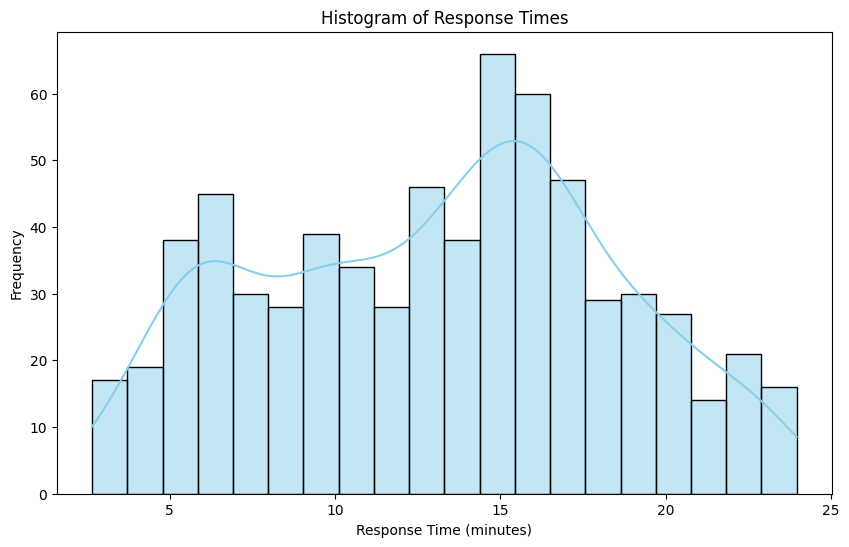

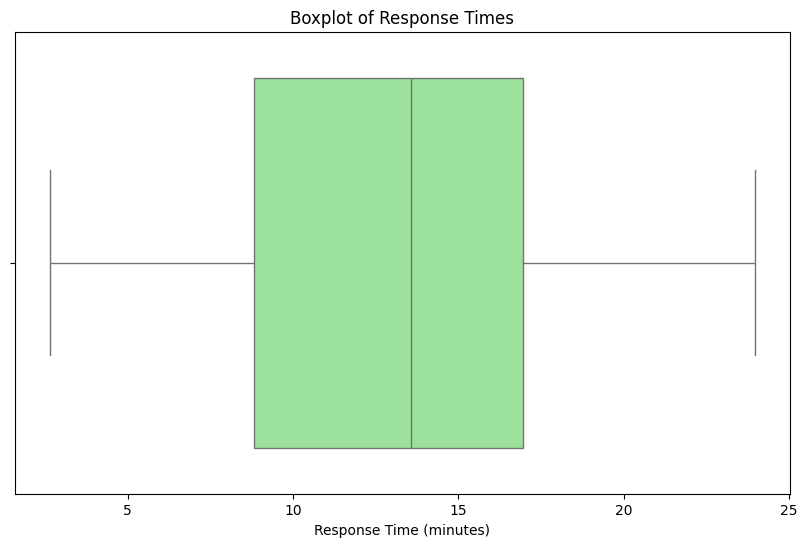

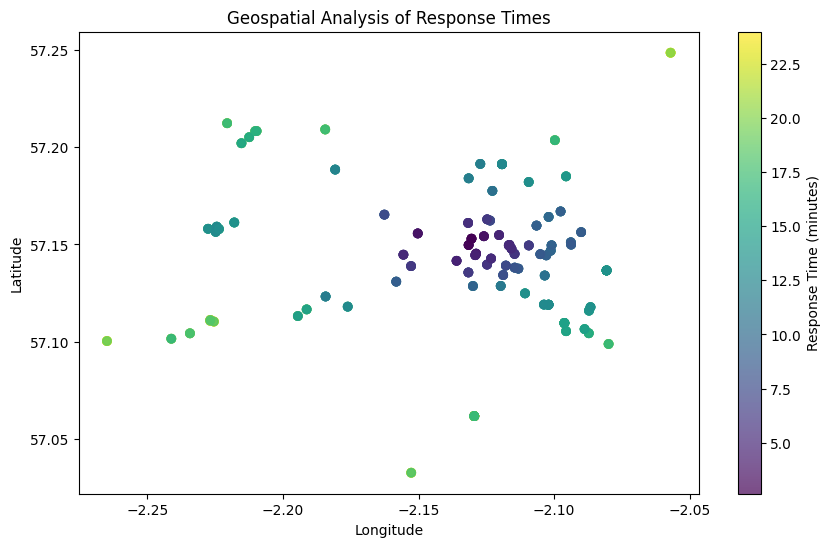

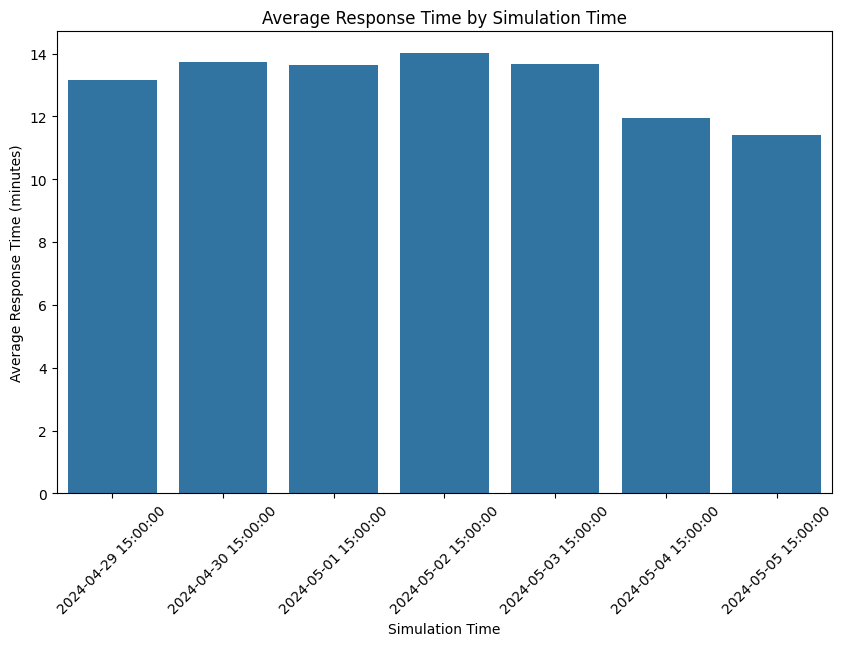

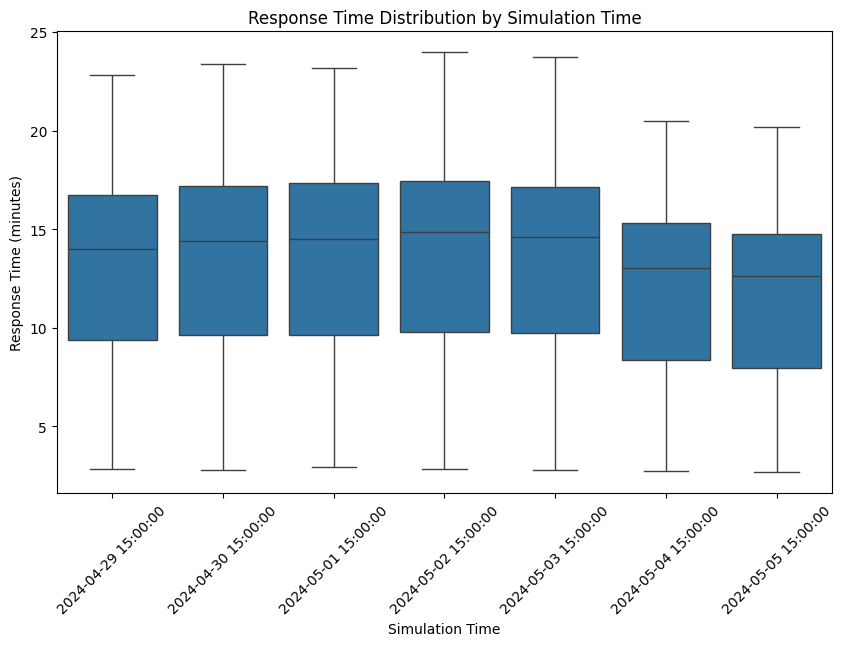

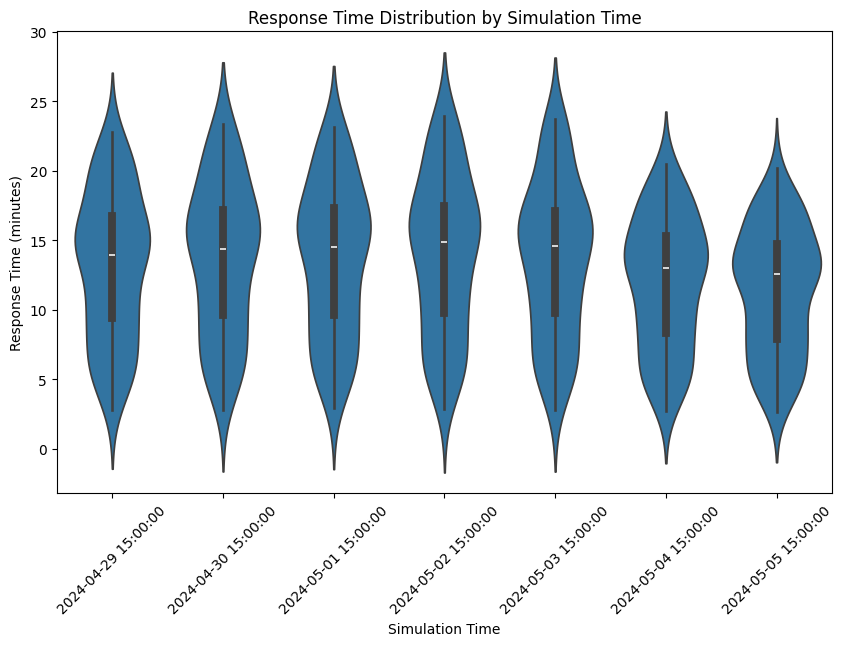

In [ ]:
# Plot Histogram of Response Times
plot_histogram(df, 'Response Time', bins=20, color='skyblue', title='Histogram of Response Times', xlabel='Response Time (minutes)')

# Plot Boxplot of Response Times
plot_boxplot(df, 'Response Time', color='lightgreen', title='Boxplot of Response Times', xlabel='Response Time (minutes)')

# Plot Geospatial Analysis (assuming 'Lat' and 'Lng' columns exist in df)
plot_geospatial_analysis(df, 'Addresses Lat', 'Addresses Lng', 'Response Time', title='Geospatial Analysis of Response Times')

# Plot Average Response Time by Simulation Time
plot_aggregated_stats(df, 'Simulation Time', 'Response Time')

# Plot Boxplot of Response Time by Simulation Time
plot_boxplot_by_time(df, 'Simulation Time', 'Response Time')

# Plot Violin Plot of Response Time by Simulation Time
plot_violinplot_by_time(df, 'Simulation Time', 'Response Time')


## Data analysis of one ambulance station

In [ ]:
file_path_one_station = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15.xlsx"
sheet_name = 'RT_(2024-05-01_15)'
df_one_station = clean_response_time(file_path_one_station, sheet_name)

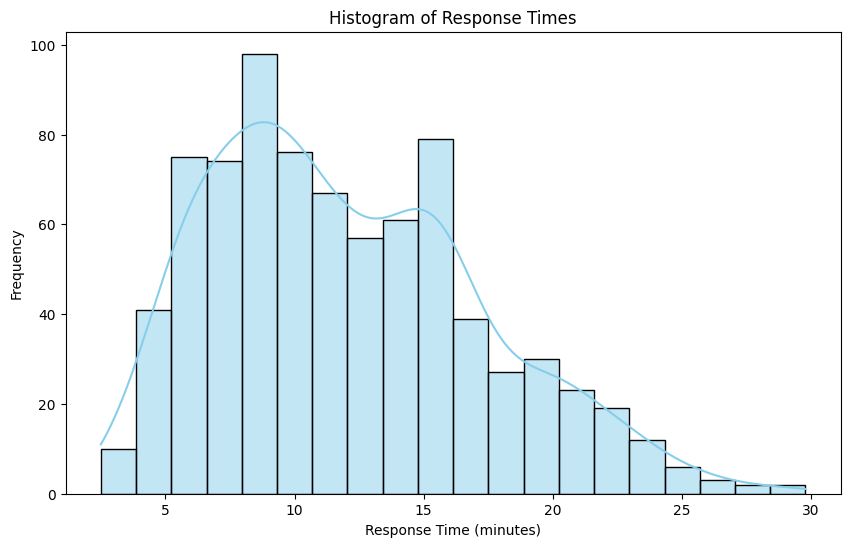

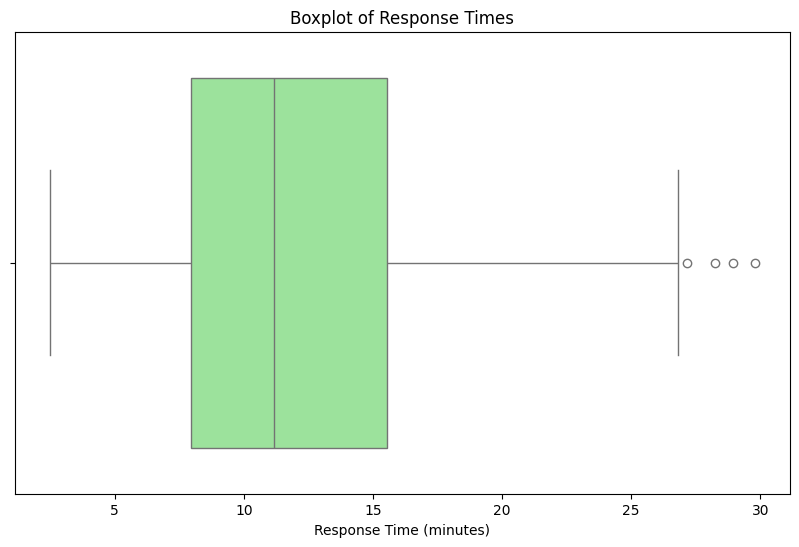

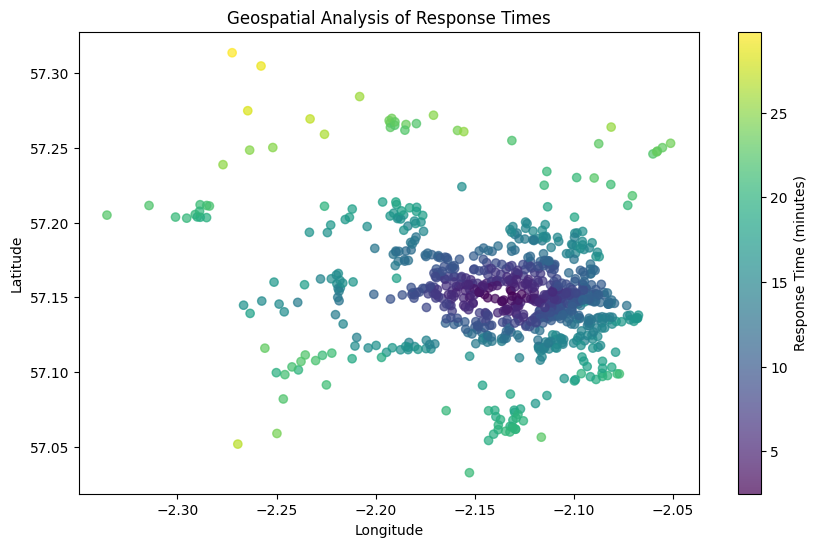

In [ ]:
# Plot Histogram of Response Times
plot_histogram(df_one_station, 'Response Time', bins=20, color='skyblue', title='Histogram of Response Times', xlabel='Response Time (minutes)')

# Plot Boxplot of Response Times
plot_boxplot(df_one_station, 'Response Time', color='lightgreen', title='Boxplot of Response Times', xlabel='Response Time (minutes)')

# Plot Geospatial Analysis (assuming 'Lat' and 'Lng' columns exist in df)
plot_geospatial_analysis(df_one_station, 'Addresses Lat', 'Addresses Lng', 'Response Time', title='Geospatial Analysis of Response Times')


## Data analysis time of day

In [ ]:
file_path_one_station = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15.xlsx"
sheet_name = 'RT_(2024-05-01_15)'
df_one_station = clean_response_time(file_path_one_station, sheet_name)
stations = ['Aberdeen Royal Infirmary, Foresterhill, Aberdeen, UK']

In [ ]:
# Plot Histogram of Response Times
plot_histogram(df_one_station, 'Response Time', bins=20, color='skyblue', title='Histogram of Response Times', xlabel='Response Time (minutes)')

# Plot Boxplot of Response Times
plot_boxplot(df_one_station, 'Response Time', color='lightgreen', title='Boxplot of Response Times', xlabel='Response Time (minutes)')

# Plot Geospatial Analysis (assuming 'Lat' and 'Lng' columns exist in df)
plot_geospatial_analysis(d_one_station, 'Addresses Lat', 'Addresses Lng', 'Response Time', title='Geospatial Analysis of Response Times')

# Plot Average Response Time by Simulation Time
plot_aggregated_stats(df, 'Simulation Time', 'Response Time')

# Plot Boxplot of Response Time by Simulation Time
plot_boxplot_by_time(df, 'Simulation Time', 'Response Time')

# Plot Violin Plot of Response Time by Simulation Time
plot_violinplot_by_time(df, 'Simulation Time', 'Response Time')

## Data analysis of multiple ambulance stations

In [ ]:
# Example usage
file_path_one_station = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_one_station_2024-05-01_15.xlsx"
file_path_Bridge_of_Don = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_Bridge_of_Don_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_Bridge_of_Don_station_2024-05-01_15.xlsx"
file_path_Kincorth = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_one_Kincorth_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_one_Kincorth_station_2024-05-01_15.xlsx"
file_path_Bucks_Burn = "/content/drive/My Drive/Modelling_Ambulance/Response_time_for_1000_calls_time_of_day_Bucks_Burn_station_2024-05-01_15/Response_time_for_1000_calls_time_of_day_Bucks_Burn_station_2024-05-01_15.xlsx"
sheet_name = 'RT_(2024-05-01_15)'  # Assuming the same sheet name format is applicable

df_one_station = clean_response_time(file_path_one_station, sheet_name)
df_Bridge_of_Don = clean_response_time(file_path_Bridge_of_Don, sheet_name)
df_Kincorth = clean_response_time(file_path_Kincorth, sheet_name)
df_Bucks_Burn = clean_response_time(file_path_Bucks_Burn, sheet_name)

In [ ]:
# Calculate average response times
avg_one_station = df_one_station['Response Time'].mean()
avg_bridge_of_don = df_Bridge_of_Don['Response Time'].mean()
avg_kincorth = df_Kincorth['Response Time'].mean()
avg_bucks_burn = df_Bucks_Burn['Response Time'].mean()

# Create a DataFrame to display the results
avg_times_df = pd.DataFrame({
    "Configuration": ["One Station", "Bridge of Don", "Kincorth", "Bucks Burn"],
    "Average Response Time (minutes)": [avg_one_station, avg_bridge_of_don, avg_kincorth, avg_bucks_burn]
})

print(avg_times_df)

   Configuration  Average Response Time (minutes)
0    One Station                        12.023013
1  Bridge of Don                        10.143154
2       Kincorth                         9.744049
3     Bucks Burn                        10.198044


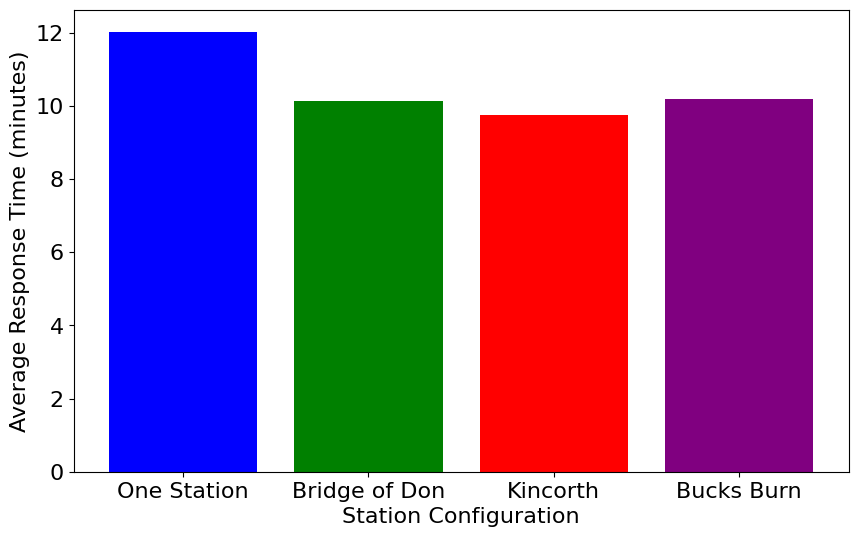

In [ ]:
# Example data
configurations = ["One Station", "Bridge of Don", "Kincorth", "Bucks Burn"]
average_times = [avg_one_station, avg_bridge_of_don, avg_kincorth, avg_bucks_burn]

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(configurations, average_times, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Station Configuration', fontsize=16)
plt.ylabel('Average Response Time (minutes)', fontsize=16)

# Adjusting tick size
plt.xticks(fontsize=16)  # Adjust x-axis tick size
plt.yticks(fontsize=16)  # Adjust y-axis tick size

plt.show()



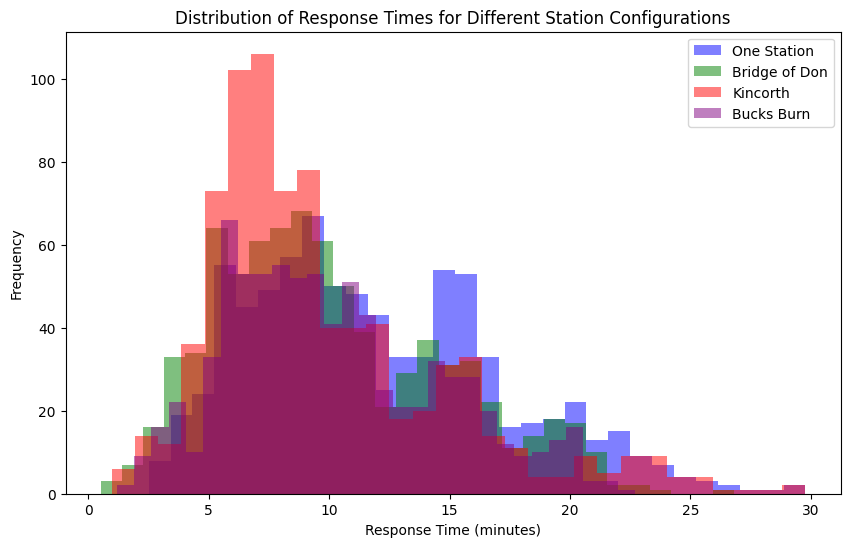

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram to show the distribution of response times for different station configurations
plt.figure(figsize=(10, 6))

# Plotting histograms with different colors
plt.hist(df_one_station['Response Time'], bins=30, alpha=0.5, label='One Station', color='blue')
plt.hist(df_Bridge_of_Don['Response Time'], bins=30, alpha=0.5, label='Bridge of Don', color='green')
plt.hist(df_Kincorth['Response Time'], bins=30, alpha=0.5, label='Kincorth', color='red')
plt.hist(df_Bucks_Burn['Response Time'], bins=30, alpha=0.5, label='Bucks Burn', color='purple')

# Adding title and labels
plt.title('Distribution of Response Times for Different Station Configurations')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


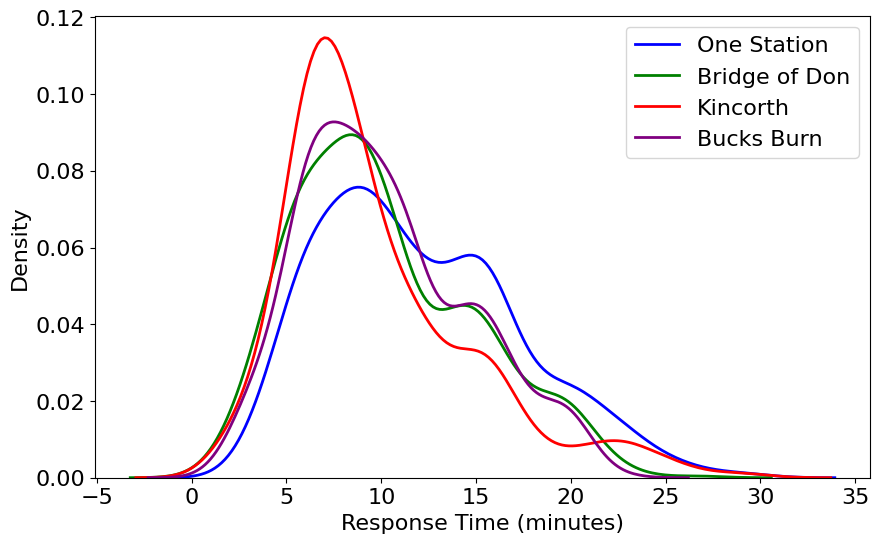

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure to show the distribution of response times for different station configurations
plt.figure(figsize=(10, 6))

# Plotting KDE plots with different colors
sns.kdeplot(df_one_station['Response Time'], label='One Station', color='blue', linewidth=2)
sns.kdeplot(df_Bridge_of_Don['Response Time'], label='Bridge of Don', color='green', linewidth=2)
sns.kdeplot(df_Kincorth['Response Time'], label='Kincorth', color='red', linewidth=2)
sns.kdeplot(df_Bucks_Burn['Response Time'], label='Bucks Burn', color='purple', linewidth=2)

# Adding title and labels
plt.xlabel('Response Time (minutes)', fontsize=16)
plt.ylabel('Density', fontsize=16)
# Adjusting tick size
plt.xticks(fontsize=16)  # Adjust x-axis tick size
plt.yticks(fontsize=16)  # Adjust y-axis tick size
plt.legend(fontsize=16)

# Show the plot
plt.show()


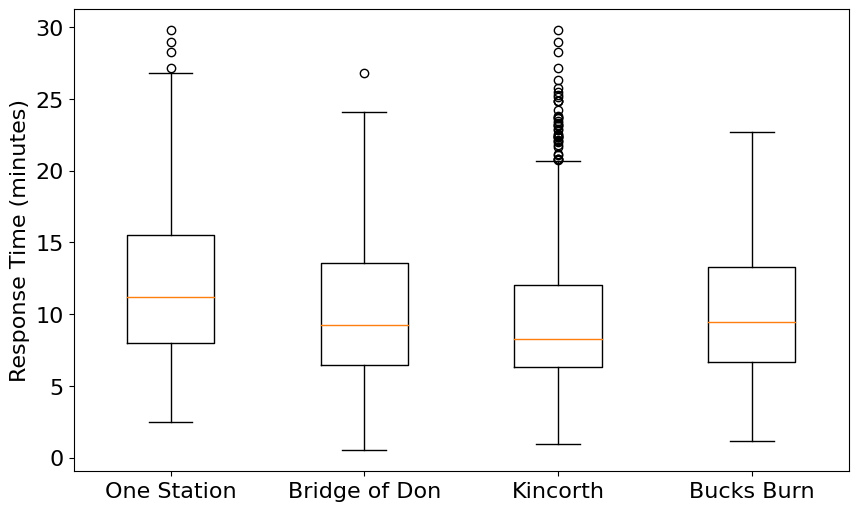

In [ ]:
import matplotlib.pyplot as plt

# Create a boxplot to compare response times across the different datasets
data = [df_one_station['Response Time'], df_Bridge_of_Don['Response Time'],
        df_Kincorth['Response Time'], df_Bucks_Burn['Response Time']]
labels = ['One Station', 'Bridge of Don', 'Kincorth', 'Bucks Burn']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)  # Remove labelsize from here
plt.ylabel('Response Time (minutes)', fontsize=16)

# Adjusting tick size using tick_params
plt.tick_params(axis='both', which='major', labelsize=16)  # This will adjust the tick size for both axes

plt.show()



Idea is to get distance traveled from api. This way we understand the impact of traffic.

## Random

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Station Address').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# For different times
# Plot Average Response Time by Simulation Time
plot_aggregated_stats(df, 'Simulation Time', 'Response Time')

# Plot Boxplot of Response Time by Simulation Time
plot_boxplot_by_time(df, 'Simulation Time', 'Response Time')

# Plot Violin Plot of Response Time by Simulation Time
plot_violinplot_by_time(df, 'Simulation Time', 'Response Time')